Load packages and models

In [1]:
from datetime import datetime
from efficientnet_pytorch import EfficientNet
from torch import nn
import pandas as pd
import pandas_path
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image as pil_image
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from PIL import Image as pil_image
import random
from torch.nn import functional as F
import cv2
import sys
from Datalaoder_3chanv2 import DatasetWIND
from Dataloader_LSTM_time_ocean3 import DatasetWIND_seq, collate_fn_padd, collate_fn_padd2
import sklearn.model_selection
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.nn.utils.rnn import pad_packed_sequence as unpack
from sklearn import preprocessing

torch.backends.cudnn.benchmark=True

In [2]:
class SwishImplementation(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_tensors[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))

class MemoryEfficientSwish(nn.Module):
    def forward(self, x):
        return SwishImplementation.apply(x)

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        model=EfficientNet.from_pretrained('efficientnet-b0',in_channels=3)
        
        model._fc=nn.Identity()
        
        self.cnn = model
        self.fc1 = nn.Linear(1282, 32)
        self.fc2 = nn.Linear(32, 1)
        self.bn   = nn.BatchNorm1d(32)
        self.swish1 =MemoryEfficientSwish()
        self.swish2 =MemoryEfficientSwish()
        
        
    def forward(self, image, data, time):
        x1 = self.cnn(image)
        x2 = data
        x3 = time
        
        x = torch.cat((x1,x2,x3), dim=1)
        x = self.swish1(self.fc1(x))
        x = self.bn(x)
        x = self.swish2(self.fc2(x))
        
        return x
        

    
        

cnn = MyModel()

Loaded pretrained weights for efficientnet-b0


load weights

In [3]:
cp=torch.load(r'G:\HU\model\EffnetB0_2021-01-27 05-08-38_77.55594927031792.pt',map_location=('cuda:0'))


cnn.load_state_dict(cp["state_dict"])


cnn.eval()

MyModel(
  (cnn): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_

Load validation Data

In [4]:
DATA_PATH =r'G:\HU\Data'

DATA_PATH2 =r'C:\Users\Michael\Desktop\ML'

train_metadata = pd.read_csv(DATA_PATH + "/training_set_features.csv")
train_labels = pd.read_csv(DATA_PATH +"/training_set_labels.csv")

full_metadata = train_metadata.merge(train_labels, on="image_id")

full_metadata["file_name"] = (
    DATA_PATH2 + "/train/" + full_metadata.image_id.path.with_suffix(".jpg")
)

images_per_storm = full_metadata.groupby("storm_id").size().to_frame("images_per_storm")
full_metadata = full_metadata.merge(images_per_storm, how="left", on="storm_id")

storm_counts = train_metadata.groupby("storm_id").size()
df=pd.DataFrame(storm_counts,columns=["counts"]).reset_index()
df["class"]=1*(df.counts>100)+1*(df.counts>200)+1*(df.counts>300)+1*(df.counts>400)+1*(df.counts>500)+1*(df.counts>600)

sss = sklearn.model_selection.StratifiedShuffleSplit(n_splits=1,  test_size=0.2,random_state=999)
split = sss.split(df, df["class"])

for a,b in split:
    IDs_train=df.iloc[a].storm_id
    IDs_val=df.iloc[b].storm_id

train=full_metadata[full_metadata["storm_id"].isin(IDs_train)].drop(
    ["images_per_storm",], axis=1
)
val=full_metadata[full_metadata["storm_id"].isin(IDs_val)].drop(
    ["images_per_storm",], axis=1
)  
    
print(train.head())
print(val.head())

  image_id storm_id  relative_time  ocean  wind_speed  \
0  abs_000      abs              0      2          43   
1  abs_001      abs           1800      2          44   
2  abs_002      abs           5400      2          45   
3  abs_003      abs          17999      2          52   
4  abs_004      abs          19799      2          53   

                                       file_name  
0  C:\Users\Michael\Desktop\ML/train/abs_000.jpg  
1  C:\Users\Michael\Desktop\ML/train/abs_001.jpg  
2  C:\Users\Michael\Desktop\ML/train/abs_002.jpg  
3  C:\Users\Michael\Desktop\ML/train/abs_003.jpg  
4  C:\Users\Michael\Desktop\ML/train/abs_004.jpg  
   image_id storm_id  relative_time  ocean  wind_speed  \
57  acd_000      acd              0      1          30   
58  acd_001      acd           1800      1          30   
59  acd_002      acd           3600      1          30   
60  acd_003      acd           5400      1          30   
61  acd_004      acd          12598      1          30   

  

In [5]:
transform_val =A.Compose(
    [
        A.transforms.CenterCrop(224,224,always_apply=True),
        A.transforms.Normalize (mean=(0.485, ), std=(0.229, ), max_pixel_value=255.0, p=1.0,always_apply=True),
        ToTensorV2()
    ]
)

transform_rot =A.Compose(
    [
        A.transforms.CenterCrop(224,224,always_apply=True),
        A.augmentations.transforms.ShiftScaleRotate(shift_limit=0, scale_limit=0, rotate_limit=180,p=1),
        A.transforms.Normalize (mean=(0.485, ), std=(0.229, ), max_pixel_value=255.0,  p=1.0,always_apply=True),
        ToTensorV2()
    ]
)

transform_val

Compose([
  CenterCrop(always_apply=True, p=1.0, height=224, width=224),
  Normalize(always_apply=True, p=1.0, mean=(0.485,), std=(0.229,), max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

In [6]:
Batchsize=32
val_set=DatasetWIND(x_train=val.drop("wind_speed",axis=1),transforms=transform_val,y_train=val["wind_speed"])
valloader1=torch.utils.data.DataLoader(val_set,batch_size=Batchsize,shuffle=False,num_workers=16,pin_memory=True)


data_set=DatasetWIND(x_train=full_metadata.drop("wind_speed",axis=1),transforms=transform_val,y_train=full_metadata["wind_speed"])
valloader=torch.utils.data.DataLoader(data_set,batch_size=Batchsize,shuffle=False,num_workers=16,pin_memory=True)
data_set_rot=DatasetWIND(x_train=full_metadata.drop("wind_speed",axis=1),transforms=transform_rot,y_train=full_metadata["wind_speed"])
valloader_rot=torch.utils.data.DataLoader(data_set_rot,batch_size=Batchsize,shuffle=False,num_workers=16,pin_memory=True)

Validation loop 

In [7]:
def valLoop2(dataloader,model):
    loop=tqdm(enumerate(dataloader, 0),total=len(dataloader),position=0, leave=True)
    df=pd.DataFrame(columns=["image_id","Prediction","WSPD",])
               
    model.cuda()
    model.eval()
    with torch.no_grad():
        for i, data in loop:
            # get the inputs; data is a list of [inputs, labels]
            inputs_val = data["image"].cuda()
            ocean_val = data["ocean"].float().view(-1,1).cuda()-1
            time_val = data["time"].float().view(-1,1).cuda()
            
            labels_val = data["label"].float().view(-1,1).cuda()

            outputs_val = model(image=inputs_val, data=ocean_val, time=time_val)
            


            d={"image_id":data["image_id"],
               "Prediction":outputs_val.cpu().detach().numpy().flatten(),
               "WSPD":labels_val.cpu().detach().numpy().flatten()}
            df2=pd.DataFrame(d)
            df=df.append(df2)

            # print statistics
            

    df=df.merge(val.drop("wind_speed",axis=1),how='left',on="image_id")
    df["MSE"]=(df["Prediction"]-df["WSPD"])**2
    X_plot = np.linspace(20, 140, 100)
    plt.plot(X_plot, X_plot, color='r')
    sns.scatterplot(data=df, x="WSPD", y="Prediction", hue="ocean",palette="deep")   
    plt.show()

    return df

100%|██████████| 439/439 [00:26<00:00, 16.36it/s]


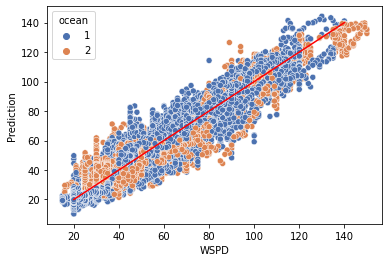

In [8]:
df_eff0=valLoop2(valloader1,cnn)

In [9]:
np.mean(df_eff0["MSE"])

77.83495

In [10]:
def average_smooth(df,h,test=False,mode="mean"):
    
    df2=df.copy()
    df2["Prediction_sm_9h"]=df2["Prediction"]

    n=df2.shape[0]
    k=df2.shape[1]

    for s in range(n):
        storm_id=df2["storm_id"][s]
        time=df2["relative_time"][s]
        time_min=np.max([0,time-60*60*h])
        filt=(df2["storm_id"]==storm_id) & (df2["relative_time"]>=time_min) & (df2["relative_time"]<=time)
        
        if mode == "median":
            df2.iloc[s,k-1]=np.median(df2[filt]["Prediction"])
        elif mode == "linreg":
            LR = LinearRegression()
            
            Y  = df2[filt]["Prediction"].values.reshape(-1, 1)
            X  = df2[filt]["relative_time"].values.reshape(-1, 1)
            j  = X.shape[0]
            
            if j>2:
                LR.fit(X,Y)
                df2.iloc[s,k-1]=LR.predict(time.reshape(1, -1))[0][0]
            else:
                df2.iloc[s,k-1]=np.mean(Y)
        else:
            df2.iloc[s,k-1]=np.mean(df2[filt]["Prediction"])
        
    if test==False:
        df2["MSE_sm"]=(df2["Prediction_sm_9h"]-df2["WSPD"])**2
        
    return(df2)


In [26]:
df_val=df_eff0

In [27]:
df_val_3=average_smooth(df=df_val,h=3)
df_val_6=average_smooth(df=df_val,h=6)
df_val_9=average_smooth(df=df_val,h=9)
df_val_12=average_smooth(df=df_val,h=12)

In [28]:
MSE_sm_3=np.mean(df_val_3["MSE_sm"])
print("MSE sm 3 = ",MSE_sm_3)

MSE_sm_6=np.mean(df_val_6["MSE_sm"])
print("MSE sm 6 = ",MSE_sm_6)

MSE_sm_9=np.mean(df_val_9["MSE_sm"])
print("MSE sm 9 = ",MSE_sm_9)

MSE_sm_12=np.mean(df_val_12["MSE_sm"])
print("MSE sm 12 = ",MSE_sm_12)

MSE sm 3 =  69.607414
MSE sm 6 =  67.143295
MSE sm 9 =  69.02841
MSE sm 12 =  74.1852


In [13]:
MSE_val=np.mean(df_val["MSE"])
print("MSE total  = ",MSE_val)

MSE_val_1=np.mean(df_val[df_val["ocean"]==1]["MSE"])
print("MSE ocean1 = ",MSE_val_1)

MSE_val_2=np.mean(df_val[df_val["ocean"]==2]["MSE"])
print("MSE ocean2 = ", MSE_val_2)

MSE total  =  77.83495
MSE ocean1 =  74.32224
MSE ocean2 =  84.34122


In [15]:
cnn1 = MyModel()
cnn2 = MyModel()
cnn3 = MyModel()
cnn4 = MyModel()
cnn5 = MyModel()

Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0


In [16]:
cp1=torch.load(r'G:\HU\model\EffnetB0_2021-01-27 03-31-22_78.29660888413362.pt',map_location=('cuda:0'))
cp2=torch.load(r'G:\HU\model\EffnetB0_2021-01-27 02-47-00_80.18609904482587.pt',map_location=('cuda:0'))
cp3=torch.load(r'G:\HU\model\EffnetB0_2021-01-27 02-41-34_83.40417106167874.pt',map_location=('cuda:0'))
cp4=torch.load(r'G:\HU\model\EffnetB0_2021-01-27 02-19-34_84.48574522904764.pt',map_location=('cuda:0'))
cp5=torch.load(r'G:\HU\model\EffnetB0_2021-01-27 02-14-06_90.66937189058726.pt',map_location=('cuda:0'))

cnn1.load_state_dict(cp1["state_dict"])
cnn2.load_state_dict(cp2["state_dict"])
cnn3.load_state_dict(cp3["state_dict"])
cnn4.load_state_dict(cp4["state_dict"])
cnn5.load_state_dict(cp5["state_dict"])

<All keys matched successfully>

100%|██████████| 439/439 [00:25<00:00, 17.51it/s]


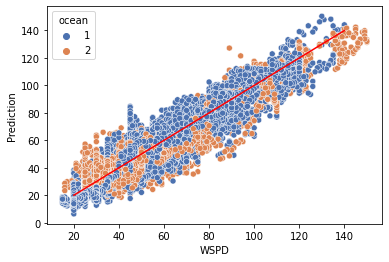

100%|██████████| 439/439 [00:26<00:00, 16.55it/s]


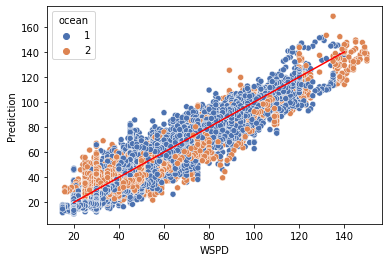

100%|██████████| 439/439 [00:26<00:00, 16.64it/s]


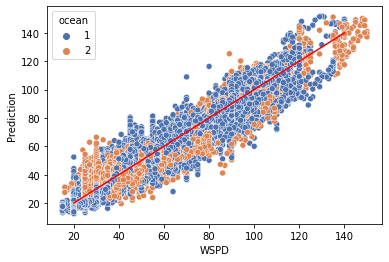

100%|██████████| 439/439 [00:24<00:00, 17.67it/s]


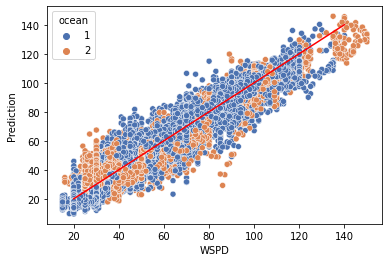

100%|██████████| 439/439 [00:27<00:00, 16.18it/s]


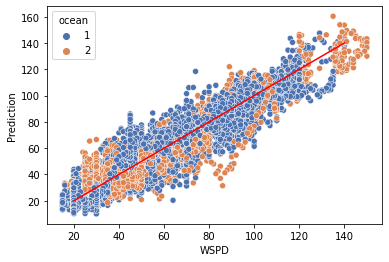

In [17]:
df_val1=valLoop2(valloader1,cnn1)
df_val2=valLoop2(valloader1,cnn2)
df_val3=valLoop2(valloader1,cnn3)
df_val4=valLoop2(valloader1,cnn4)
df_val5=valLoop2(valloader1,cnn5)

In [18]:
df_val=df_val[["image_id","Prediction","WSPD"]]
df_val_comb=df_val.merge(df_val1[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb["Prediction"]=df_val_comb.drop(["image_id","WSPD"],axis=1).mean(axis=1)
df_val_comb=df_val_comb.merge(val,how="left",on="image_id")
np.mean((df_val_comb["Prediction"]-df_val_comb["WSPD"])**2)

77.2745

In [19]:
df_val=df_val[["image_id","Prediction","WSPD"]]
df_val_comb=df_val.merge(df_val1[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_val2[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb["Prediction"]=df_val_comb.drop(["image_id","WSPD"],axis=1).mean(axis=1)
df_val_comb=df_val_comb.merge(val,how="left",on="image_id")
np.mean((df_val_comb["Prediction"]-df_val_comb["WSPD"])**2)

77.45052

In [20]:
df_val=df_val[["image_id","Prediction","WSPD"]]
df_val_comb=df_val.merge(df_val1[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_val2[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_val3[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb["Prediction"]=df_val_comb.drop(["image_id","WSPD"],axis=1).mean(axis=1)
df_val_comb=df_val_comb.merge(val,how="left",on="image_id")
np.mean((df_val_comb["Prediction"]-df_val_comb["WSPD"])**2)

76.164505

In [21]:
df_val=df_val[["image_id","Prediction","WSPD"]]
df_val_comb=df_val.merge(df_val1[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_val2[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_val3[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_val4[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb["Prediction"]=df_val_comb.drop(["image_id","WSPD"],axis=1).mean(axis=1)
df_val_comb=df_val_comb.merge(val,how="left",on="image_id")
np.mean((df_val_comb["Prediction"]-df_val_comb["WSPD"])**2)

75.34192

In [22]:
df_val=df_val[["image_id","Prediction","WSPD"]]
df_val_comb=df_val.merge(df_val1[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_val2[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_val3[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_val4[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_val5[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb["Prediction"]=df_val_comb.drop(["image_id","WSPD"],axis=1).mean(axis=1)
df_val_comb=df_val_comb.merge(val,how="left",on="image_id")
np.mean((df_val_comb["Prediction"]-df_val_comb["WSPD"])**2)

75.39486

In [23]:
df_val_3=average_smooth(df=df_val_comb,h=3)
df_val_6=average_smooth(df=df_val_comb,h=6)
df_val_9=average_smooth(df=df_val_comb,h=9)
df_val_12=average_smooth(df=df_val_comb,h=12)

In [24]:
MSE_sm_3=np.mean(df_val_3["MSE_sm"])
print("MSE sm 3 = ",MSE_sm_3)

MSE_sm_6=np.mean(df_val_6["MSE_sm"])
print("MSE sm 6 = ",MSE_sm_6)

MSE_sm_9=np.mean(df_val_9["MSE_sm"])
print("MSE sm 9 = ",MSE_sm_9)

MSE_sm_12=np.mean(df_val_12["MSE_sm"])
print("MSE sm 12 = ",MSE_sm_12)

MSE sm 3 =  68.562996
MSE sm 6 =  67.20624
MSE sm 9 =  69.915634
MSE sm 12 =  75.54773


In [29]:
np.sqrt(67.20624)

8.197941204961158

In [30]:
val_set_rot=DatasetWIND(x_train=val.drop("wind_speed",axis=1),transforms=transform_rot,y_train=val["wind_speed"])
valloader2=torch.utils.data.DataLoader(val_set_rot,batch_size=Batchsize,shuffle=False,num_workers=16,pin_memory=True)

100%|██████████| 439/439 [00:29<00:00, 15.12it/s]


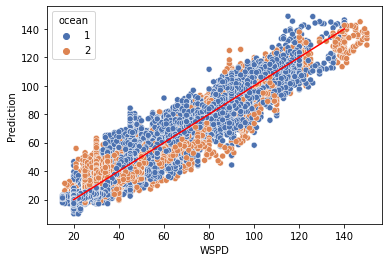

In [31]:
df_val_rot1=valLoop2(valloader2,cnn)

In [32]:
np.mean(df_val_rot1["MSE"])

83.1116

100%|██████████| 439/439 [00:27<00:00, 16.23it/s]


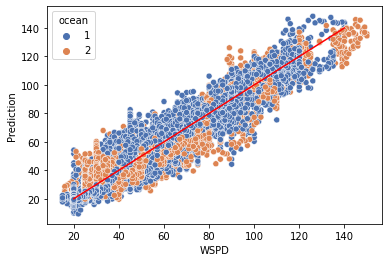

In [33]:
df_val_rot2=valLoop2(valloader2,cnn)

In [34]:
np.mean(df_val_rot2["MSE"])

82.542336

In [35]:
df_val=df_val[["image_id","Prediction","WSPD"]]
df_val_comb=df_val.merge(df_val_rot1[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb["Prediction"]=df_val_comb.drop(["image_id","WSPD"],axis=1).mean(axis=1)
df_val_comb=df_val_comb.merge(val,how="left",on="image_id")
np.mean((df_val_comb["Prediction"]-df_val_comb["WSPD"])**2)

77.34022

In [36]:
df_val=df_val[["image_id","Prediction","WSPD"]]
df_val_comb=df_val.merge(df_val_rot1[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_val_rot2[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb["Prediction"]=df_val_comb.drop(["image_id","WSPD"],axis=1).mean(axis=1)
df_val_comb=df_val_comb.merge(val,how="left",on="image_id")
np.mean((df_val_comb["Prediction"]-df_val_comb["WSPD"])**2)

77.03375

In [37]:
df_val_3=average_smooth(df=df_val_comb,h=3)
df_val_6=average_smooth(df=df_val_comb,h=6)
df_val_9=average_smooth(df=df_val_comb,h=9)
df_val_12=average_smooth(df=df_val_comb,h=12)

In [38]:
MSE_sm_3=np.mean(df_val_3["MSE_sm"])
print("MSE sm 3 = ",MSE_sm_3)

MSE_sm_6=np.mean(df_val_6["MSE_sm"])
print("MSE sm 6 = ",MSE_sm_6)

MSE_sm_9=np.mean(df_val_9["MSE_sm"])
print("MSE sm 9 = ",MSE_sm_9)

MSE_sm_12=np.mean(df_val_12["MSE_sm"])
print("MSE sm 12 = ",MSE_sm_12)

MSE sm 3 =  68.99498
MSE sm 6 =  66.81723
MSE sm 9 =  68.82734
MSE sm 12 =  74.04207


100%|██████████| 439/439 [00:26<00:00, 16.44it/s]


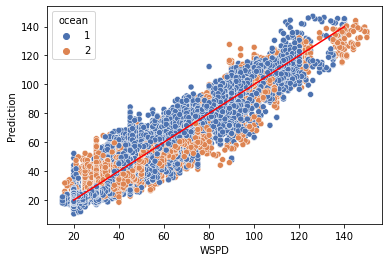

100%|██████████| 439/439 [00:27<00:00, 16.24it/s]


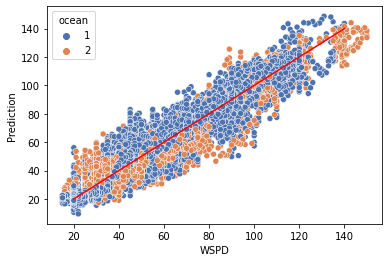

100%|██████████| 439/439 [00:26<00:00, 16.37it/s]


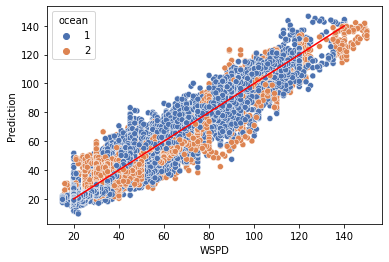

In [39]:
df_val_rot3=valLoop2(valloader2,cnn)
df_val_rot4=valLoop2(valloader2,cnn)
df_val_rot5=valLoop2(valloader2,cnn)

In [40]:
df_val=df_val[["image_id","Prediction","WSPD"]]
df_val_comb=df_val.merge(df_val_rot1[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_val_rot2[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_val_rot3[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb["Prediction"]=df_val_comb.drop(["image_id","WSPD"],axis=1).mean(axis=1)
df_val_comb=df_val_comb.merge(val,how="left",on="image_id")
np.mean((df_val_comb["Prediction"]-df_val_comb["WSPD"])**2)

76.83904

In [41]:
df_val=df_val[["image_id","Prediction","WSPD"]]
df_val_comb=df_val.merge(df_val_rot1[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_val_rot2[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_val_rot3[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_val_rot4[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb["Prediction"]=df_val_comb.drop(["image_id","WSPD"],axis=1).mean(axis=1)
df_val_comb=df_val_comb.merge(val,how="left",on="image_id")
np.mean((df_val_comb["Prediction"]-df_val_comb["WSPD"])**2)

76.77191

In [42]:
df_val=df_val[["image_id","Prediction","WSPD"]]
df_val_comb=df_val.merge(df_val_rot1[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_val_rot2[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_val_rot3[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_val_rot4[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_val_rot5[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb["Prediction"]=df_val_comb.drop(["image_id","WSPD"],axis=1).mean(axis=1)
df_val_comb=df_val_comb.merge(val,how="left",on="image_id")
np.mean((df_val_comb["Prediction"]-df_val_comb["WSPD"])**2)

76.71468

In [43]:
df_val_3=average_smooth(df=df_val_comb,h=3)
df_val_6=average_smooth(df=df_val_comb,h=6)
df_val_9=average_smooth(df=df_val_comb,h=9)
df_val_12=average_smooth(df=df_val_comb,h=12)

In [44]:
MSE_sm_3=np.mean(df_val_3["MSE_sm"])
print("MSE sm 3 = ",MSE_sm_3)

MSE_sm_6=np.mean(df_val_6["MSE_sm"])
print("MSE sm 6 = ",MSE_sm_6)

MSE_sm_9=np.mean(df_val_9["MSE_sm"])
print("MSE sm 9 = ",MSE_sm_9)

MSE_sm_12=np.mean(df_val_12["MSE_sm"])
print("MSE sm 12 = ",MSE_sm_12)

MSE sm 3 =  69.06766
MSE sm 6 =  66.97093
MSE sm 9 =  68.998764
MSE sm 12 =  74.19605


In [6]:
submission_format = pd.read_csv(
    DATA_PATH + "/submission_format.csv", index_col="image_id"
)

test_metadata = pd.read_csv(DATA_PATH + "/test_set_features.csv")
test_metadata["file_name"] = (
    DATA_PATH + "/test/"+ test_metadata.image_id.path.with_suffix(".jpg")
)

storms=list(test_metadata["storm_id"].unique())
test_metadata = test_metadata.append(full_metadata[full_metadata["storm_id"].isin(storms)]).drop(["wind_speed"],axis=1)

Batchsize=32
test_dataset=DatasetWIND(x_train=test_metadata,transforms=transform_val)
test_dataloader=torch.utils.data.DataLoader(test_dataset,batch_size=Batchsize,shuffle=False,num_workers=16,pin_memory=True)

test_dataset_rot=DatasetWIND(x_train=test_metadata,transforms=transform_rot)
test_dataloader_rot=torch.utils.data.DataLoader(test_dataset_rot,batch_size=Batchsize,shuffle=False,num_workers=16,pin_memory=True)

In [7]:
def valLoop3(dataloader,model):
    loop=tqdm(enumerate(dataloader, 0),total=len(dataloader),position=0, leave=True)
    df=pd.DataFrame(columns=["image_id","Prediction"])
               
    model.cuda()
    model.eval()
    with torch.no_grad():
        for i, data in loop:
            # get the inputs; data is a list of [inputs, labels]
            inputs_val = data["image"].cuda()
            ocean_val = data["ocean"].float().view(-1,1).cuda()-1
            time_val = data["time"].float().view(-1,1).cuda()
            
            

            outputs_val = model(image=inputs_val, data=ocean_val, time=time_val)
            


            d={"image_id":data["image_id"],
               "Prediction":outputs_val.cpu().detach().numpy().flatten()
               }
            df2=pd.DataFrame(d)
            df=df.append(df2)

            # print statistics
            

    df=df.merge(test_metadata,how='left',on="image_id")
    

    return df

In [8]:
df_test=valLoop3(test_dataloader,cnn)
df_test_rot1=valLoop3(test_dataloader_rot,cnn)
df_test_rot2=valLoop3(test_dataloader_rot,cnn)

100%|██████████| 2055/2055 [03:53<00:00,  8.81it/s]


In [12]:
df_test_sm_6=average_smooth(df=df_test,h=6,test="true")

In [13]:
df_test_sm_6["wind_speed"]=round(df_test_sm_6["Prediction_sm_9h"]).astype(int)

submission_frame=df_test_sm_6[["image_id","wind_speed"]].set_index("image_id")
submission_frame

,wind_speed
image_id,
acd_123,23
acd_124,22
acd_125,22
acd_126,22
acd_127,22
...,...
zza_056,33
zza_057,33
zza_058,33


In [14]:
sub=submission_format.merge(submission_frame,how="left",on="image_id").drop("wind_speed_x",axis=1)
sub.columns=["wind_speed"]

In [15]:
today = datetime.now()
sub.to_csv((DATA_PATH + "/submission-effnetb0-3ch-past"+today.strftime("%Y-%m-%d %H-%M-%S")+".csv"), index=True)

In [17]:
df_val=df_test[["image_id","Prediction"]]
df_val_comb=df_val.merge(df_test_rot1[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb=df_val_comb.merge(df_test_rot2[["image_id","Prediction"]],how="left",on="image_id")
df_val_comb["Prediction"]=df_val_comb.drop(["image_id"],axis=1).mean(axis=1)
df_val_comb=df_val_comb.merge(test_metadata,how="left",on="image_id")

In [18]:
df_test_sm_6_rot=average_smooth(df=df_val_comb,h=6,test="true")

In [19]:
df_test_sm_6_rot["wind_speed"]=round(df_test_sm_6_rot["Prediction_sm_9h"]).astype(int)
submission_frame=df_test_sm_6_rot[["image_id","wind_speed"]].set_index("image_id")
submission_frame

,wind_speed
image_id,
acd_123,25
acd_124,24
acd_125,24
acd_126,24
acd_127,23
...,...
zza_056,34
zza_057,34
zza_058,34


In [20]:
sub=submission_format.merge(submission_frame,how="left",on="image_id").drop("wind_speed_x",axis=1)
sub.columns=["wind_speed"]

In [21]:
today = datetime.now()
sub.to_csv((DATA_PATH + "/submission-effnetb0-3ch-past-3rot-6h"+today.strftime("%Y-%m-%d %H-%M-%S")+".csv"), index=True)

In [22]:
df_test_sm_9_rot=average_smooth(df=df_val_comb,h=9,test="true")
df_test_sm_9_rot["wind_speed"]=round(df_test_sm_9_rot["Prediction_sm_9h"]).astype(int)
submission_frame=df_test_sm_9_rot[["image_id","wind_speed"]].set_index("image_id")
sub=submission_format.merge(submission_frame,how="left",on="image_id").drop("wind_speed_x",axis=1)
sub.columns=["wind_speed"]
today = datetime.now()
sub.to_csv((DATA_PATH + "/submission-effnetb0-3ch-past-3rot-9h-"+today.strftime("%Y-%m-%d %H-%M-%S")+".csv"), index=True)